In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

#define the device (cpu or gpu) and data type (float32 or float64) we'll use. 
#GPUs can be used on google colab by changing the runtime type
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32

A basic tutorial on modelling the probability distribution of a toy data set, consisting of a superposition of the low- and high-temperature configurations of a 1D Ising model, using recurrent neural networks.

In [2]:
def toy_1d_ising(N, L):
    states=np.random.choice([0, 1], size=(N,L))
    states_up = np.ones((N, L))
    states_down = np.zeros((N,L))
    states = np.concatenate((states, states_up, states_down))
    np.random.shuffle(states)
    return states[:N]

#energy and magnetization of states with open boundary conditions
def energy(states):
    states = (2*states - 1) 
    return -1*np.sum(states[:,:-1]* np.roll(states,-1, axis = 1)[:,:-1], axis = 1)
def magnetization(states):
    states = (2*states - 1) 
    return np.sum(states, axis = 1)



We want to learn the probability distribution of these samples, $P(\mathbf{x})\equiv P(x_1, x_2, \cdots, x_N)$. We can model this distribution in an autoregressive way: \begin{equation}
P(\mathbf{x}) = \Pi_{i=1}^N P(x_i|\{x_{j<i}\}),
\end{equation}
where $P(x_i|\{x_{j<i}\})$ is the conditional probability of $x_i$ given the previous values $\{x_{j<i}\}$. These conditional probabilities are modelled with a recurrent neural network (RNN). An RNN (in its basic form) receives at each site as input a previous "hidden" state $h_{i-1}$ and previous spin state $x_{i-1}$, and calculates a new hidden state $h_i$. This hidden state is then further processed to the normalized conditional probability $P(x_i|\{x_{j<i}\})$. New states can then also be drawn from $P(\mathbf{x})$ by sequentially sampling the conditional probabilities. To optimize the RNN, we minimize the negative log likelihood of the training data, which is equivalent to minimizing the KL-divergence.

In [3]:
class RNN_Ising(torch.nn.Module):
    def __init__(self, N, input_dim, hidden_dim):
        super(RNN_Ising, self).__init__()

        self.N = N
        self.input_dim = input_dim # number of possible values the local variables can have
        self.hidden_dim = hidden_dim #Dimension of the hidden state


        #A GRU cell receives an input and hidden state, and from this calculates a new hidden state. 
        #The cell will be applied to each lattice site sequentially.
        #.to() converts a pytorch module/tensor to a different device/dtype
        self.rnn_cell = torch.nn.GRUCell(self.input_dim, hidden_dim).to(dtype)

        #These hidden states are then processed to the conditional probabilities P(x_i|\{x_{j<i}\}).
        #To do so, the hidden state vector for each lattice site is first transformed to a vector with dimension equal to the number of possible states. 
        #This is done with a fully-connected neural network through torch.nn.Linear(x,y) where x and y are the dimension of the input and output-vector respectively.
        #This vector is then passed through a softmax activation, which normalizes the vector. The normalization is done over dim = 1, as dim = 0 is the batch dimension.
        #These two operations are combined in a torch.nn.Sequential, which makes a sequential model of an arbitrary number of layers and activation functions.
        #The conditional probability is then defined as the product between this vector and the spin state.
        self.dense = torch.nn.Sequential(torch.nn.Linear(self.hidden_dim, self.input_dim), torch.nn.Softmax(dim=1)).to(dtype) 

    #calculate the log likelihood of provided data samples in parallel (i.e. process a whole batch at once)
    def log_prob(self, samples):
        numsamples = samples.shape[0]
        #The samples have dimension (batch, self.N). We need to transform each spin value to a one-hot encoding (i.e. 0 -> (1 0) and 1 -> (0 1)).
        one_hot_samples = torch.nn.functional.one_hot(samples.to(torch.int64), num_classes = self.input_dim).to(dtype)
        cond_probs = torch.zeros(numsamples, self.N,  dtype=dtype, device = device)

        #The initial hidden and input state are defined as zero-vectors.
        hidden_state = torch.zeros(numsamples, self.hidden_dim, dtype=dtype, device=device)
        inputs = torch.zeros(numsamples, self.input_dim, dtype=dtype, device=device)

        #traverse the 1D lattice
        for i in range(self.N):
            #calculate new hidden state
            hidden_state = self.rnn_cell(inputs, hidden_state)
            
            #apply the layer which returns a normalized conditional probability vector over the possible spin states
            output_prob = self.dense(hidden_state)

            #calculate conditional probabilities
            #This is done by taking the product between the normalized conditional probability vector and the one-hot encoded spin states.
            #This results in a scalar value P(x_i|\{x_{j<i}\})
            cond_probs[:, i] = (output_prob * one_hot_samples[:,i]).sum(dim = 1)

            #Select the input for the next site
            inputs = one_hot_samples[:,i]

        #The log probability of the entire sample is then found by summing over the conditional log probabilities.
        log_prob = torch.log(cond_probs).sum(dim=1)
        return log_prob

    #We don't need to record gradients while sampling, telling our model not to do this makes it faster
    @torch.no_grad()
    def sample(self,numsamples):

        samples = torch.zeros(numsamples, self.N,  dtype=dtype, device = device)

        #The initial hidden and input state are defined as zero-vectors.
        hidden_state = torch.zeros(numsamples, self.hidden_dim, dtype=dtype, device=device)
        inputs = torch.zeros(numsamples, self.input_dim, dtype=dtype, device=device)

        for i in range(self.N):
            #calculate new hidden state
            hidden_state = self.rnn_cell(inputs, hidden_state)
            
            #apply softmax layer
            output_prob = self.dense(hidden_state)

            #sample from conditional probability vector.
            #torch.multinomial(x, N) draws N samples from the probability distribution x.
            sampled_site = torch.multinomial(output_prob,1)[:,0]
            samples[:,i] = sampled_site

            #This sampled site is then used as input for the next site
            inputs = torch.nn.functional.one_hot(sampled_site, num_classes=self.input_dim).to(dtype)
        return samples

    def train(self, train_set, test_set, num_epochs, bSize, lr):

        #Define the optimizer which will be used to update our weights. This requires a list of all the model parameters and a learning rate.
        optim = torch.optim.Adam(list(self.rnn_cell.parameters()) + list(self.dense.parameters()), lr = lr)
        
        #These loaders allow for easy iterating over a data set.
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=bSize, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=bSize, shuffle=False)
        
        train_loss = torch.zeros(num_epochs)
        test_loss = torch.zeros(num_epochs)

        for i in range(num_epochs):

            running_train_loss = 0
            running_test_loss = 0


            for (batch_idx, batch) in enumerate(train_loader):
                optim.zero_grad() #set the gradients of each model parameter back to zero.
                
                loss = -1*torch.mean(self.log_prob(batch)) #calculate the loss on the batch, here the negative log likelihood
                loss.backward() #backpropagate the loss
                optim.step() #Update all model parameters according to the loss gradient.

                running_train_loss+=loss.item() #.item() returns the value of a tensor as a standard Python number
            train_loss[i] = running_train_loss/(batch_idx+1)

            #Don't need to record gradients over test set, explicitly saying so makes this faster
            with torch.no_grad():
                for (batch_idx, batch) in enumerate(test_loader):
                    loss = torch.mean(-self.log_prob(batch))
                    running_test_loss+=loss.item()

                test_loss[i] = running_test_loss/(batch_idx+1)
            if i % 50 == 0:    
                print("Epoch: "+str(i+1)+"   train loss: " +str(train_loss[i])+"   test loss: " +str( test_loss[i]))
        return train_loss, test_loss

Epoch: 1   train loss: tensor(13.6076)   test loss: tensor(13.3205)
Epoch: 51   train loss: tensor(6.1861)   test loss: tensor(6.3170)
Epoch: 101   train loss: tensor(5.8080)   test loss: tensor(5.9446)
Epoch: 151   train loss: tensor(5.7595)   test loss: tensor(5.8877)


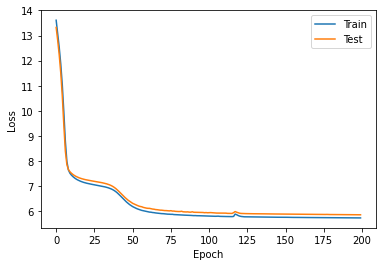

In [4]:
N_train = 10000
N_test = 1000
L= 20

#Generate a training and testing set. The latter will be used to test how well we generalize
train_set = torch.from_numpy(toy_1d_ising(N_train, L)).to(dtype).to(device)        
test_set = torch.from_numpy(toy_1d_ising(N_test, L)).to(dtype).to(device)        

#Create an RNN model, and move it to GPU if using through .to(device)
rnn = RNN_Ising(L, 2, 32).to(device)
train_loss, test_loss = rnn.train(train_set, test_set, 200,200, 1e-4)

plt.plot(train_loss, label = "Train")
plt.plot(test_loss, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

Once trained, we can sample from the RNN and see whether it has learned the correct distribution of some observables.

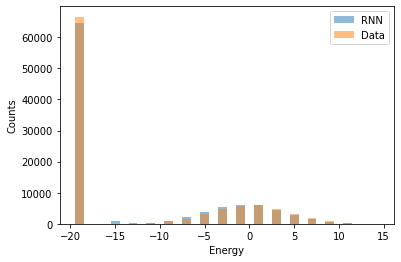

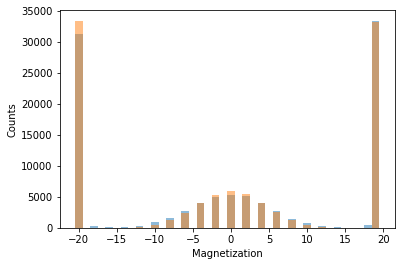

In [5]:
samples =rnn.sample(100000).cpu().numpy() 
states = toy_1d_ising(100000, L)

plt.hist(energy(samples), alpha =0.5, bins=np.arange(min(energy(samples)), max(energy(samples)) + 1, 1),  align= 'left', label = "RNN")
plt.hist(energy(states), alpha =0.5, bins=np.arange(min(energy(states)), max(energy(states)) + 1, 1), align= 'left', label = "Data")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.legend()
plt.show()

plt.hist(magnetization(samples), alpha =0.5, bins=np.arange(min(magnetization(samples)), max(magnetization(samples)) + 1, 1),  align= 'left')
plt.hist(magnetization(states), alpha =0.5, bins=np.arange(min(magnetization(states)), max(magnetization(states)) + 1, 1),  align= 'left')
plt.xlabel("Magnetization")
plt.ylabel("Counts")

plt.show()

